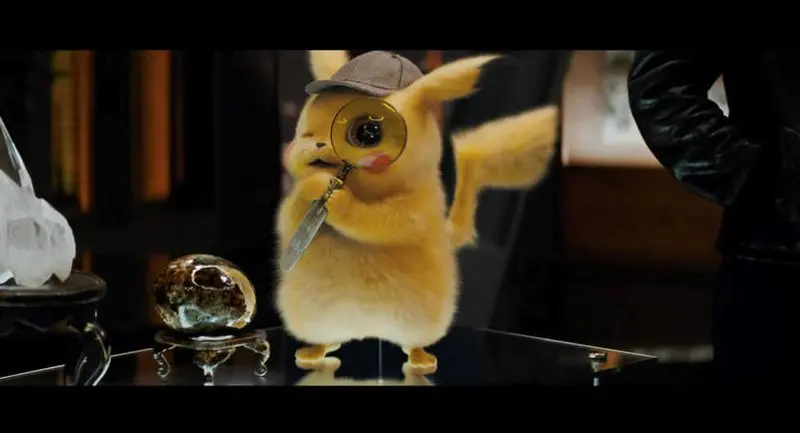


> # !!!!!!!!!!!!!!!!!!!!!NOTE!!!!!!!!!!!!!!!!!!!!!!
# 
# Comments after @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
#  should be uncommented for Final MY Bert notebook. They are commented for implementing base models(W2V, Bert, Elmo)

In [ ]:
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import json
import tensorflow.keras.layers as L
from keras.layers import Dropout
import seaborn as sns
import tensorflow as tf
import plotly.express as px
from sklearn.preprocessing import quantile_transform,StandardScaler,MinMaxScaler
from transformers import BertConfig,TFBertModel,BertModel
from keras.callbacks import EarlyStopping
import random
import math, json, os, random
from matplotlib import pyplot as plt


In [ ]:
np.random.seed(100)
random.seed(100)
EnergyFlag=0
UnpaireFlag=1


In [ ]:
train = pd.read_json('/kaggle/input/stanford-covid-vaccine/train.json', lines=True)
test = pd.read_json('/kaggle/input/stanford-covid-vaccine/test.json', lines=True)
sample_df = pd.read_csv('/kaggle/input/stanford-covid-vaccine/sample_submission.csv')
print(pd.Series(list(train['structure'][0])).value_counts())
print(pd.Series(list(train['sequence'][0])).value_counts())
print(pd.Series(list(train['predicted_loop_type'][0])).value_counts())

In [ ]:
def read_bpps_sum(df):
    bpps_arr = []
    for mol_id in df.id.to_list():
        bpps_arr.append(np.load(f"../input/stanford-covid-vaccine/bpps/{mol_id}.npy").sum(axis=1))
    return bpps_arr

def read_bpps_max(df):
    bpps_arr = []
    for mol_id in df.id.to_list():
        bpps_arr.append(np.load(f"../input/stanford-covid-vaccine/bpps/{mol_id}.npy").max(axis=1))
    return bpps_arr

def read_bpps_nb(df):
    #mean and std from https://www.kaggle.com/symyksr/openvaccine-deepergcn 
    bpps_nb_mean = 0.077522
    bpps_nb_std = 0.08914
    bpps_arr = []
    for mol_id in df.id.to_list():
        bpps = np.load(f"../input/stanford-covid-vaccine/bpps/{mol_id}.npy")
        bpps_nb = (bpps > 0).sum(axis=0) / bpps.shape[0]
        bpps_nb = (bpps_nb - bpps_nb_mean) / bpps_nb_std
        bpps_arr.append(bpps_nb)
    return bpps_arr 

train['bpps_sum'] = read_bpps_sum(train)
test['bpps_sum'] = read_bpps_sum(test)
train['bpps_max'] = read_bpps_max(train)
test['bpps_max'] = read_bpps_max(test)
train['bpps_nb'] = read_bpps_nb(train)
test['bpps_nb'] = read_bpps_nb(test)

#sanity check
train.head()

fig, ax = plt.subplots(3, figsize=(15, 10))
sns.kdeplot(np.array(train['bpps_max'].to_list()).reshape(-1),
            color="Blue", ax=ax[0], label='Train')
sns.kdeplot(np.array(test[test['seq_length'] == 107]['bpps_max'].to_list()).reshape(-1),
            color="Red", ax=ax[0], label='Public test')
sns.kdeplot(np.array(test[test['seq_length'] == 130]['bpps_max'].to_list()).reshape(-1),
            color="Green", ax=ax[0], label='Private test')
sns.kdeplot(np.array(train['bpps_sum'].to_list()).reshape(-1),
            color="Blue", ax=ax[1], label='Train')
sns.kdeplot(np.array(test[test['seq_length'] == 107]['bpps_sum'].to_list()).reshape(-1),
            color="Red", ax=ax[1], label='Public test')
sns.kdeplot(np.array(test[test['seq_length'] == 130]['bpps_sum'].to_list()).reshape(-1),
            color="Green", ax=ax[1], label='Private test')
sns.kdeplot(np.array(train['bpps_nb'].to_list()).reshape(-1),
            color="Blue", ax=ax[2], label='Train')
sns.kdeplot(np.array(test[test['seq_length'] == 107]['bpps_nb'].to_list()).reshape(-1),
            color="Red", ax=ax[2], label='Public test')
sns.kdeplot(np.array(test[test['seq_length'] == 130]['bpps_nb'].to_list()).reshape(-1),
            color="Green", ax=ax[2], label='Private test')

ax[0].set_title('Distribution of bpps_max')
ax[1].set_title('Distribution of bpps_sum')
ax[2].set_title('Distribution of bpps_nb')
plt.tight_layout();

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

In [ ]:
# This will tell us the columns we are predicting
pred_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

In [ ]:

def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=1)

def gru_layer(hidden_dim, dropout):
    return L.Bidirectional(L.GRU(hidden_dim, dropout=dropout, return_sequences=True))

from kerastuner import HyperModel

####################################################################### Uncomment for Fine Tuning

# class BertHyperModel(HyperModel):
#     def __init__(self, seq_len, pred_len):
#         self.seq_len = seq_len
#         self.pred_len = pred_len


#     def build(self, hp):
#         #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

# #         ids = L.Input(shape=(self.seq_len,4), dtype=tf.int32)
# #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
#         ids = L.Input(shape=(5,self.seq_len,), dtype=tf.int32)

#         flat = L.Flatten()(ids)

#         config = BertConfig() 
#         config.vocab_size = hp.Choice(
#                     'vocab_size',
#                     values=[13,14,130],
#                     default=13
#                 )
#         config.num_hidden_layers = hp.Choice(
#                     'num_hidden_layers',
#                     values=[2,4,8,16],
#                     default=2
#                 )
#         config.num_attention_heads = hp.Choice(
#                     'num_attention_heads',
#                     values=[1,2,4,8],
#                     default=1
#                 )
#         config.attention_probs_dropout_prob  = hp.Float(
#                     'attention_probs_dropout_prob',
#                     min_value=0.1,
#                     max_value=0.5,
#                     default=0.5,
#                     step=0.1
            
#                 )
#         config.hidden_size = hp.Choice(
#                     'hidden_size',
#                     values=[120],
#                     default=120
#                 )
        
#         config.hidden_act= tf.sinh #tf.tanh
#         config.max_position_embeddings=2048
        
#         bert_model = TFBertModel(config=config)
#         print('flat',flat.shape)
#         bert_embeddings = bert_model(flat)[0]
# #         bert_embeddings=L.GaussianNoise(stddev=hp.Float(
# #                         'GaussianNoise',
# #                         min_value=0.1,
# #                         max_value=0.8,
# #                         sampling='LOG',
# #                         default=0.1
# #                     ))(bert_embeddings)
#         hidden = L.AveragePooling1D(pool_size=hp.Choice(
#                     'pool_size',
#                     values=[2,4,8],
#                     default=2,
#                 ))(bert_embeddings)
#         # Since we are only making predictions on the first part of each sequence, we have
#         # to truncate it
#         hidden=L.GaussianNoise(stddev=hp.Float(
#                         'GaussianNoise2',
#                         min_value=0.01,
#                         max_value=0.8,
#                         sampling='LOG',
#                         default=0.01
#                     ))(hidden)


        
#         truncated = hidden[:,:self.pred_len, :]
# #         Dense1 = L.Dense(units=hp.Int(
# #                     'units',
# #                     min_value=64,
# #                     max_value=512,
# #                     step=32,
# #                     default=64
# #                 ), activation=hp.Choice('dense_activation',values=['relu', 'tanh', 'sigmoid'],
# #                     default='relu'))(truncated)        
                    
#         Dense2= L.Dropout(hp.Float('dropout_1',min_value=0.0,max_value=0.5,default=0.0,step=0.05))(truncated)

#         out = L.Dense(5, activation='linear')(Dense2)

#         model = tf.keras.Model(inputs=ids, outputs=out)

#         model.compile(tf.keras.optimizers.Adam(hp.Float(
#                     'learning_rate',
#                     min_value=1e-4,
#                     max_value=1e-2,
#                     sampling='LOG',
#                     default=1e-3
#                 )), loss=MCRMSE)
#         model.summary()
#         return model
####################################################################### Uncomment for Fine Tuning
def build_model(seq_len=107, pred_len=68, dropout=0.5, embed_dim=100, hidden_dim=128):

        ids = L.Input(shape=(5,seq_len,), dtype=tf.int32)
#         categorical_feats = ids[:, :, :3]
#         numerical_feats = ids[:, :, 3:]
#         embeddings =tf.keras.layers.Embedding(name='token_encoding',input_dim=len(token2int),output_dim=200)
#         inputs = embeddings(categorical_feats)
# #           inputs: Tensor("token_encoding/embedding_lookup/Identity_1:0", shape=(?, 107, 3, 200)
#         reshaped = tf.reshape(inputs, shape=(-1, inputs.shape[1],  inputs.shape[2] * inputs.shape[3]))
#         reshaped = tf.cast(reshaped, dtype=tf.int32)
#         reshaped = tf.keras.layers.concatenate([reshaped, numerical_feats], axis=2)
            
            
        flat = L.Flatten()(ids)

        config = BertConfig() 
        config.vocab_size = 14
        config.num_hidden_layers =4
        config.num_attention_heads = 2
        config.attention_probs_dropout_prob  =0.5
        config.hidden_size = 120
        config.hidden_act= tf.sinh #tf.tanh
        config.max_position_embeddings=2048
        bert_model = TFBertModel(config=config)
        bert_embeddings = bert_model(flat)[0]
#         bert_embeddings=L.GaussianNoise(stddev=hp.Float(
#                         'GaussianNoise',
#                         min_value=0.1,
#                         max_value=0.8,
#                         sampling='LOG',
#                         default=0.1
#                     ))(bert_embeddings)
        hidden = L.AveragePooling1D(pool_size=2)(bert_embeddings)
        # Since we are only making predictions on the first part of each sequence, we have
        # to truncate it
        hidden=L.GaussianNoise(stddev=0.2)(hidden)
        truncated = hidden[:,:pred_len, :]
#         Dense1 = L.Dense(units=hp.Int(
#                     'units',
#                     min_value=64,
#                     max_value=512,
#                     step=32,
#                     default=64
#                 ), activation=hp.Choice('dense_activation',values=['relu', 'tanh', 'sigmoid'],
#                     default='relu'))(truncated)        
                    
        Dense2= L.Dropout(0.2)(truncated)

        out = L.Dense(5, activation='linear')(Dense2)

        model = tf.keras.Model(inputs=ids, outputs=out)

        model.compile(tf.keras.optimizers.Adam(), loss=mcrmse)
        model.summary()
        return model


In [ ]:
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

# vocab = {
#     'sequence': {x:i for i, x in enumerate("A C G U".split())},
#     'structure': {x:i for i, x in enumerate("( . )".split())},
#     'predicted_loop_type': {x:i for i, x in enumerate("B E H I M S X".split())},
# }
# def preprocess_inputs(df, cols=['sequence', 'structure', 'predicted_loop_type']):
    
#     def f(x):
#         return [vocab['sequence'][x] for x in x[0]],\
#                 [vocab['structure'][x] for x in x[1]],\
#                 [vocab['predicted_loop_type'][x] for x in x[2]]
                

#     return np.array(df[cols].apply(f, axis=1).values.tolist()
#         )
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
token2int = {x:i for i, x in enumerate('().ACGUBEHIMSX')}
def preprocess_inputs(df, cols=['sequence', 'structure', 'predicted_loop_type']):
    base_fea = np.transpose(
        np.array(
            df[cols]
            .applymap(lambda seq: [token2int[x] for x in seq])
            .values
            .tolist()
        ),
        (0, 2, 1)
    )
    bpps_sum_fea = np.array(df['bpps_sum'].to_list())[:,:,np.newaxis]
    bpps_max_fea = np.array(df['bpps_max'].to_list())[:,:,np.newaxis]
    return np.transpose(np.concatenate([base_fea,bpps_sum_fea,bpps_max_fea], 2),(0, 2, 1))

if DENOISE:
    train = train[train['signal_to_noise'] > .25]
    
    
    # https://www.kaggle.com/c/stanford-covid-vaccine/discussion/183211
def rmse(y_actual, y_pred):
    mse = tf.keras.losses.mean_squared_error(y_actual, y_pred)
    return K.sqrt(mse)

def mcrmse(y_actual, y_pred, num_scored=len(target_cols)):
    score = 0
    for i in range(num_scored):
        score += rmse(y_actual[:, :, i], y_pred[:, :, i]) / num_scored
    return score

Load and preprocess data

*Eden vectors of sequences*

In [ ]:
import pickle
with open("../input/shakerdrivenfeatures/EdenvecsTest.txt", "rb") as fps:   # Unpickling
   EdenTestvecs = pickle.load(fps)
   print(len(EdenTestvecs),type(EdenTestvecs))


with open("../input/shakerdrivenfeatures/EdenvecsTrain.txt", "rb") as fp:   # Unpickling
   EdenTrainvecs = pickle.load(fp)
   print(len(EdenTrainvecs),type(EdenTrainvecs),type(EdenTrainvecs[0]),EdenTrainvecs[0].shape)


In [ ]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# train = pd.read_json('/kaggle/input/stanford-covid-vaccine/train.json', lines=True)
# test = pd.read_json('/kaggle/input/stanford-covid-vaccine/test.json', lines=True)
# sample_df = pd.read_csv('/kaggle/input/stanford-covid-vaccine/sample_submission.csv')
# print(pd.Series(list(train['structure'][0])).value_counts())
# print(pd.Series(list(train['sequence'][0])).value_counts())
# print(pd.Series(list(train['predicted_loop_type'][0])).value_counts())
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

Add extraxted Features to test and traindatasets

In [ ]:
# EnergyFeatureVecTest=np.array(test.iloc[:,7:19].values.tolist())
# EnergyFeatureVecTrain=np.array(train.iloc[:,7:19].values.tolist())
# EnergyFeatureVecTrain.shape


*energy features of structures from RNAplFold added up to trainset*

In [ ]:
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# trainEnergy = pd.read_json('../input/shakerdrivenfeatures/TrainEnergiesV2.json')
# trainEnergy=train.merge(trainEnergy, left_index=True, right_index=True)
# trainEnergy.rename(columns={'sequence_x':'sequence'}, inplace=True)
# del trainEnergy['sequence_y']
# train=trainEnergy
# testEnergy  = pd.read_json('../input/shakerdrivenfeatures/TestEnergiesV2.json')
# testEnergy=test.merge(testEnergy, left_index=True, right_index=True)
# testEnergy.rename(columns={'sequence_x':'sequence'}, inplace=True)
# del testEnergy['sequence_y']
# test=testEnergy
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


*unpaired probabilities from vienna*

In [ ]:
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

# trainUnpaired = pd.read_json('../input/shakerdrivenfeatures/TrainUnpairedProbabilities.json')

# testUnpaired = pd.read_json('../input/shakerdrivenfeatures/TestUnpaired.json')

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


merge [unpaired test] with [enrge+raw test] so as to filter private and public test sets from seq length

In [ ]:
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

# test=pd.merge(test, testUnpaired, on="sequence")
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

# a.shape
# a.iloc[:,19:]

In [ ]:
# testUnpaired.shape


In [ ]:
sorted(train['signal_to_noise'].apply(np.round).astype(int).unique())
np.bincount(train['signal_to_noise'].apply(np.round).astype(int))
sorted(train['SN_filter'].apply(np.round).astype(int).unique()) 
np.bincount(train['SN_filter'].apply(np.round).astype(int))


selects 1350 out of 2400

In [ ]:
#train = train.query("signal_to_noise >= 4")
train_inputs = preprocess_inputs(train)



In [ ]:

train_labels = np.array(train[pred_cols].values.tolist()).transpose((0, 2, 1))

train_inputs.shape


In [ ]:


# LableTrainSet=np.empty((2400,5,80))#desierd dataset
# AA=train_labels #(2400, 68, 5)

# BB=np.array(train.iloc[:,7:19].values.tolist()) #(2400,12)
# for row,i in enumerate(AA):
#  for inuc in range(AA.shape[1]):
#   APP= np.append(AA[row][inuc],BB[row])
#   LableTrainSet[row][inuc]=APP
# LableTrainSet.shape
# train_labels=LableTrainSet.transpose((0, 2, 1))


In [ ]:
trainLabels=train[pred_cols]

In [ ]:
for df in [train,test]:
    df['Paired']=[sum([i=='(' or i==')' for i in j]) for j in df['structure']]
    df['Unpaired']=[sum([i=='.' for i in j]) for j in df['structure']]
    for col in ['E','S','H','I','G','A','U']:
        if col in ['E','S','H','I']:
            df[col]=[sum([i==col for i in j])/len(j) for j in df['predicted_loop_type']]
        else:
            df[col]=[sum([i==col for i in j])/len(j) for j in df['sequence']]
for a in [ 'G', 'A', 'C', 'U']:
    train[a+'_position']=[np.sum([i for i in range(len(j)) if j[i]==a])/len([i for i in range(len(j)) if j[i]==a]) for j in train['sequence']]
    test[a+'_position']=[np.sum([i for i in range(len(j)) if j[i]==a])/len([i for i in range(len(j)) if j[i]==a]) for j in test['sequence']]
for a in [ 'E', 'S', 'H',]:
    train[a+'_position']=[np.sum([i for i in range(len(j)) if j[i]==a])/len([i for i in range(len(j)) if j[i]==a]) for j in train['predicted_loop_type']]
    test[a+'_position']=[np.sum([i for i in range(len(j)) if j[i]==a])/len([i for i in range(len(j)) if j[i]==a]) for j in test['predicted_loop_type']]
for a in [ 'E', 'S', 'H',]:
    train[a+'']=[np.sum([i for i in range(len(j)) if j[i]==a])/len([i for i in range(len(j)) if j[i]==a]) for j in train['predicted_loop_type']]
    test[a+'_position']=[np.sum([i for i in range(len(j)) if j[i]==a])/len([i for i in range(len(j)) if j[i]==a]) for j in test['predicted_loop_type']]
target_columns = ['reactivity', 'deg_Mg_pH10','deg_pH10', 'deg_Mg_50C', 'deg_50C']
target_columns.extend(['SN_filter', 'signal_to_noise'])
target_columns.extend(['deg_error_pH10', 'deg_error_Mg_50C', 'deg_error_50C', 'reactivity_error', 'deg_error_Mg_pH10'] )
train.drop(target_columns,axis=1,inplace=True)
SC = MinMaxScaler(feature_range=(-1, 1))
train_measurements = SC.fit_transform(pd.concat((train.select_dtypes('float64'),train.select_dtypes('int64')),axis=1))
train_measurements.shape

In [ ]:
# np.min(train_measurements),np.max(train_measurements)
# # np.min(test_measurements),np.max(test_measurements)
# pd.DataFrame(train_measurements).describe().T

Build and train model


In [ ]:
train_inputs.shape,train_labels.shape

Predict on test set¶


In [ ]:
public_df = test.query("seq_length == 107").copy()
private_df = test.query("seq_length == 130").copy()


In [ ]:
public_test_measurements  = SC.fit_transform(pd.concat((public_df.select_dtypes('float64'),public_df.select_dtypes('int64')),axis=1))
private_test_measurements  = SC.fit_transform(pd.concat((private_df.select_dtypes('float64'),private_df.select_dtypes('int64')),axis=1))
public_inputs = preprocess_inputs(public_df)
private_inputs = preprocess_inputs(private_df)

Public and private sets have different sequence lengths, so we will preprocess them separately and load models of different tensor shapes.



**********add feature vector of energy with size (2400,12) to the np array of daatset with size (2400,107,3).
here there are 2400 records in which we have a matrice of size (107,3). the matrice indicates 3 features for a nucleotide: nucleotide letter[G,A,C,U], Loop letter[E,S,X,B,M,I,G,H] and structure character[(,),.].
we aim to add 12 extra features regarding to the energy level to each of these 3 features. to sum up we'll have a vector of size (2400(number of seq),107(each nucleotide in seq),15(name,loop,struc,12energy_levels))******

In [ ]:
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# def ADD_UnpairedPb_Featurs_TO_DATA(train,public_df,private_df,train_inputs,public_inputs,private_inputs):
#     UnpaireFlag=1
#    ################################################################## ADD unpaired 2 Train Dataset

#     UnpairedPbTrainSet=np.empty((2400,4,107))#desierd dataset(2400,3,119)
#     A=train_inputs #(2400,3,107)
#     print(A.shape)
#     B=np.array(trainUnpaired['Unpaired_Prob'].values.tolist()) #(2400, 107)

#     for row,i in enumerate(A):
#       AP=  np.vstack((i,B[row]))
#       UnpairedPbTrainSet[row]=AP
    
#     print(UnpairedPbTrainSet.shape)
#     train_inputs=UnpairedPbTrainSet
    
    
    
#    ################################################################## ADD unpaired 2 Public Test Dataset
#     UnpairedPbpublicTestSet=np.empty((629,4,107))#desierd dataset
#     C=public_inputs #(629, 3, 107)
#     D=np.array(public_df.iloc[:,19:20].values.tolist()) #(629,107)
    
#     for row,i in enumerate(C):
#       XX= np.vstack((i,D[row]))
#       UnpairedPbpublicTestSet[row]=XX
        
#     print(UnpairedPbpublicTestSet.shape)
#     public_inputs=UnpairedPbpublicTestSet

#    ################################################################## ADD unpaired 2 Private Test Dataset

#     UnpairedPbprivateTestSet=np.empty((3005,4,130))#desierd dataset
#     E=private_inputs #(3005, 3, 130)
#     F=np.array(private_df.iloc[:,19:20].values.tolist()) #(3005,107)
    
#     for row,i in enumerate(E):
#       ZZ=np.vstack((i,F[row]))
#       UnpairedPbprivateTestSet[row]=ZZ
        
#     print(UnpairedPbprivateTestSet.shape)
#     private_inputs=UnpairedPbprivateTestSet
    
#     return train_inputs,public_inputs,private_inputs
    
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@




In [ ]:
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

# def ADD_Energy_Featurs_TO_DATA(train,public_df,private_df,train_inputs,public_inputs,private_inputs):
#     EnergyFlag=1
#     EnergyTrainSet=np.empty((2400,4,119))#desierd dataset
#     A=train_inputs #(2400,4,107)
#     B=np.array(train.iloc[:,7:19].values.tolist()) #(2400,12)
#     for row,i in enumerate(A):
#      for inuc in range(A.shape[1]):
#       AP= np.append(A[row][inuc],B[row])
#       EnergyTrainSet[row][inuc]=AP
#     EnergyTrainSet.shape
#     train_inputs=EnergyTrainSet
#     print(train_inputs.shape)

#     EnergypublicTestSet=np.empty((629,4,119))#desierd dataset
#     C=public_inputs #(629, 4, 107)
#     D=np.array(public_df.iloc[:,7:19].values.tolist()) #(629,12)
#     for row,i in enumerate(C):
#      for inuc in range(C.shape[1]):
#       XX= np.append(C[row][inuc],D[row])
#       EnergypublicTestSet[row][inuc]=XX
#     EnergypublicTestSet.shape
#     public_inputs=EnergypublicTestSet


#     EnergyprivateTestSet=np.empty((3005,4,142))#desierd dataset
#     E=private_inputs #(3005, 4, 130)
#     F=np.array(private_df.iloc[:,7:19].values.tolist()) #(3005,12)
#     for row,i in enumerate(E):
#      for inuc in range(E.shape[1]):
#       ZZ= np.append(E[row][inuc],F[row])
#       EnergyprivateTestSet[row][inuc]=ZZ
#     EnergyprivateTestSet.shape
#     private_inputs=EnergyprivateTestSet
    
#     return train_inputs,public_inputs,private_inputs
    
    
    
# train_inputs,public_inputs,private_inputs=ADD_UnpairedPb_Featurs_TO_DATA(train,
#                                                                          public_df
#                                                                          ,private_df
#                                                                          ,train_inputs
#                                                                          ,public_inputs
#                                                                          ,private_inputs)

# train_inputs,public_inputs,private_inputs=ADD_Energy_Featurs_TO_DATA(train,
#                                                                      public_df
#                                                                      ,private_df
#                                                                      ,train_inputs
#                                                                      ,public_inputs
#                                                                      ,private_inputs)

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


**Unpaired Features and Energy features in 12 temperatures have been added to both Test and Train sets np
array dimensions:**

In [ ]:
print(train_inputs.shape,public_inputs.shape,private_inputs.shape)

In [ ]:
print(train_labels.shape,train_labels.shape )

In [ ]:
from sklearn.model_selection import KFold
from kerastuner.tuners import Hyperband
from kerastuner.tuners import RandomSearch
from kerastuner import HyperParameters
import kerastuner as kt
from sklearn import ensemble
from sklearn import datasets
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import KFold
kf = KFold(n_splits=4,shuffle=True,random_state=42)

SEED=1
Seq_Len=119
Pred_Len=68
HYPERBAND_MAX_EPOCHS = 10
MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 10
N_EPOCH_SEARCH = 20
if EnergyFlag:
    Seq_Len=119
else:
    Seq_Len=107


# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2,patience=100)

# Hypermodel = BertHyperModel(seq_len=Seq_Len, pred_len=Pred_Len)


# ####  cross validation Tuner (CVTuner is overwrited as Keras still has no Tunner for NeuralNets cross validation) ###########################################
####################################################################### Uncomment for Fine Tuning

# import kerastuner
# import numpy as np
# from sklearn import model_selection

# class CVTuner(kerastuner.engine.tuner.Tuner):
#   def run_trial(self, trial, x, y, batch_size=64, epochs=1):
#     cv = KFold(n_splits=5,shuffle=True,random_state=42)
#     print(cv)
#     val_losses = []
#     for train_indices, test_indices in cv.split(x):
#       x_train, x_test = x[train_indices], x[test_indices]
# #       print("x_train, x_te?st",x_train, x_test)
#       y_train, y_test = y[train_indices], y[test_indices]
# #       print("y_train, y_test",y_train, y_test)
#       model = self.hypermodel.build(trial.hyperparameters)
#       model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)
#       val_losses.append(model.evaluate(x_test, y_test))
#     self.oracle.update_trial(trial.trial_id, {'val_loss': np.mean(val_losses)})
#     self.save_model(trial.trial_id, model)

# tuner = CVTuner(
#   hypermodel=Hypermodel,
#   oracle=kerastuner.oracles.BayesianOptimization(
#     objective='val_loss',
#     max_trials=1))

# tuner.search(train_inputs,train_labels, batch_size=64, epochs=2)

####################################################################### Uncomment for Fine Tuning




# tuner.search_space_summary()
# Show a summary of the search
# tuner.results_summary()
# Retrieve the best model.
# best_model = tuner.get_best_models(num_models=1)[0]

####################################################################### Uncomment for Fine Tuning
# hps = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters
# models=tuner.get_best_models(num_models=1)
# bestModel=models[0]
# print(hps)
# Hmodel=Hypermodel.build(hps)
####################################################################### Uncomment for Fine Tuning

################################ No cross validation Tuner ###########################################
# tuner = Hyperband(
#     Hypermodel,
#     max_epochs=HYPERBAND_MAX_EPOCHS,
#     objective= 'val_loss',
#     seed=SEED,
#     executions_per_trial=EXECUTION_PER_TRIAL,
#     directory='hyperband2',
#     project_name='111'
# ) 

# tuner = kt.tuners.Sklearn(
#     oracle=kt.oracles.BayesianOptimization(
#         objective=kt.Objective('val_loss','min'),
#         max_trials=10),
#     hypermodel=Hypermodel,
#     cv=kf,
#     directory='.',
#     project_name='123')

# tuner.search(train_inputs, train_labels, epochs=N_EPOCH_SEARCH, validation_split=0.05)











with tf.device('/gpu'):
# with strategy.scope():
    model = build_model()
    for fold,(idxT,idxV) in enumerate(kf.split(train_inputs)):
        history = model.fit(
            train_inputs[idxT,:,:], train_labels[idxT,:,:], 
            batch_size=64,
            epochs=100,
            validation_split=0.05,
                callbacks=[
            tf.keras.callbacks.ReduceLROnPlateau(),
            tf.keras.callbacks.ModelCheckpoint('model'+str(fold)+'.h5',save_weights_only=True,save_best_only=True)
        ],verbose=2
        )
        # Caveat: The prediction format requires the output to be the same length as the input,
        # although it's not the case for the training data.
####################################################################### Uncomment for Fine Tuning

#         model_short = BertHyperModel(seq_len=119, pred_len=119).build(hps)
#         model_long = BertHyperModel(seq_len=142, pred_len=142).build(hps)
####################################################################### Uncomment for Fine Tuning

        model_short = build_model(seq_len=119, pred_len=119)
        model_long = build_model(seq_len=142, pred_len=142)
        
        model_short.load_weights('model'+str(fold)+'.h5')
        model_long.load_weights('model'+str(fold)+'.h5')####use parameters instead of weights
        print('132')

        if fold == 0:
            print('134')
            public_preds =  model_short.predict([public_inputs])/5
            private_preds = model_long.predict([private_inputs])/5
            print('137')
        else:
            print('140')
            public_preds +=  model_short.predict([public_inputs])/5
            private_preds +=  model_long.predict([private_inputs])/5
            print('143')
        print('145')
        fig = px.line(
        history.history, y=['loss', 'val_loss'], 
        labels={'index': 'epoch', 'value': 'Mean Squared Error'}, 
        title='Training History')
        fig.show()

In [ ]:
private_inputs.shape

In [ ]:
train_labels.shape

In [ ]:
public_preds.shape

Post-processing and submit
For each sample, we take the predicted tensors of shape (107, 5) or (130, 5), and convert them to the long format (i.e.  629×107,5  or  3005×130,5 ):

In [ ]:
public_df

In [ ]:
public_preds.shape

In [ ]:
private_df.shape

In [ ]:
private_preds.shape

In [ ]:
preds_ls = []

for df, preds in [(public_df, public_preds), (private_df, private_preds)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=pred_cols)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        preds_ls.append(single_df)

preds_df = pd.concat(preds_ls)
submission = sample_df[['id_seqpos']].merge(preds_df, on=['id_seqpos'])
submission.to_csv('submission.csv', index=False)

In [ ]:
ls


HyperParameter Tuning

In [ ]:
# vocab_size = 13
# num_hidden_layers = 2
# num_attention_heads = 1
# attention_probs_dropout_prob  = 0.5
# hidden_size = 120
# hidden_act= tf.sinh #tf.tanh
# stddev=0.5
# pool_size=2
# units=32
# activation='relu'
# Dropout rate=0.3
# dropout=0.5,
# embed_dim=100,
# hidden_dim=128,


